## Install dependencies

In [ ]:
!pip install numpy scipy matplotlib

## Helper functions

In [134]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats


def plot_data(x, t, ax=None):
    if ax is None:
        ax = plt
    ax.scatter(x, t, marker='o', c="k", s=20)

def plot_truth(x, y, label='Truth', ax=None):
    if ax is None:
        ax = plt
    ax.plot(x, y, 'k--', label=label)

def plot_predictive(x, y, std, y_label='Prediction (mean)', std_label='Uncertainty (stdev)', plot_xy_labels=True, ax=None):
    y = y.ravel()
    std = std.ravel()

    if ax is None:
        plt.plot(x, y, label=y_label)
        plt.fill_between(x.ravel(), y + std, y - std, alpha = 0.5, label=std_label)

        if plot_xy_labels:
            plt.xlabel('x')
            plt.ylabel('y')
    else:
        ax.plot(x, y, label=y_label)
        ax.fill_between(x.ravel(), y + std, y - std, alpha = 0.5, label=std_label)

        if plot_xy_labels:
            ax.set_xlabel('x')
            ax.set_ylabel('y')

def plot_posterior_samples(x, ys, plot_xy_labels=True, ax=None):
    if ax is None:
        plt.plot(x, ys[:, 0], 'r-', alpha=0.5, label='Post. samples')
        for i in range(1, ys.shape[1]):
            plt.plot(x, ys[:, i], 'r-', alpha=0.5)

        if plot_xy_labels:
            plt.xlabel('x')
            plt.ylabel('y')
    else:
        ax.plot(x, ys[:, 0], 'r-', alpha=0.5, label='Post. samples')
        for i in range(1, ys.shape[1]):
            ax.plot(x, ys[:, i], 'r-', alpha=0.5)

        if plot_xy_labels:
            ax.set_xlabel('x')
            ax.set_ylabel('y')


def plot_posterior(mean, cov, w0, w1, ax=None):
                
    resolution = 100

    grid_x = grid_y = np.linspace(-1, 1, resolution)
    grid_flat = np.dstack(np.meshgrid(grid_x, grid_y)).reshape(-1, 2)

    densities = stats.multivariate_normal.pdf(grid_flat, mean=mean.ravel(), cov=cov).reshape(resolution, resolution)
    
    if ax is None:
        plt.imshow(densities, origin='lower', extent=(-1, 1, -1, 1))
        plt.scatter(w0, w1, marker='x', c="r", s=20, label='Truth')

        plt.xlabel('w0')
        plt.ylabel('w1')
    else:
        ax.imshow(densities, origin='lower', extent=(-1, 1, -1, 1))
        ax.scatter(w0, w1, marker='x', c="r", s=20, label='Truth')

        ax.set_xlabel('w0')
        ax.set_ylabel('w1')


## Functions

In [4]:
def posterior(Phi, t, alpha, beta, return_inverse=False):
    """Computes mean and covariance matrix of the posterior distribution."""
    S_N_inv = alpha * np.eye(Phi.shape[1]) + beta * Phi.T.dot(Phi)
    S_N = np.linalg.inv(S_N_inv)
    m_N = beta * S_N.dot(Phi.T).dot(t)

    if return_inverse:
        return m_N, S_N, S_N_inv
    else:
        return m_N, S_N

In [5]:
def posterior_predictive(Phi_test, m_N, S_N, beta):
    """Computes mean and variances of the posterior predictive distribution."""
    y = Phi_test.dot(m_N)
    # Only compute variances (diagonal elements of covariance matrix)
    y_var = 1 / beta + np.sum(Phi_test.dot(S_N) * Phi_test, axis=1)
    
    return y, y_var

## Basis function tools

In [6]:
def identity_basis_function(x):
    return x


def gaussian_basis_function(x, mu, sigma=0.1):
    return np.exp(-0.5 * (x - mu) ** 2 / sigma ** 2)


def polynomial_basis_function(x, power):
    return x ** power


def expand(x, bf, bf_args=None):
    if bf_args is None:
        return np.concatenate([np.ones(x.shape), bf(x)], axis=1)
    else:
        return np.concatenate([np.ones(x.shape)] + [bf(x, bf_arg) for bf_arg in bf_args], axis=1)

## Example Data Generator

In [7]:
f_w0 = -0.3
f_w1 =  0.5


def f(X, noise_variance):
    '''Linear function plus noise'''
    return f_w0 + f_w1 * X + noise(X.shape, noise_variance)

def g(X, noise_variance):
    '''Sinusoidial function plus noise'''
    return 0.5 + np.sin(2 * np.pi * X) + noise(X.shape, noise_variance)

def noise(size, variance):
    return np.random.normal(scale=np.sqrt(variance), size=size)

## Linear Model



In [20]:
import matplotlib.pyplot as plt
%matplotlib inline


In [136]:
beta = 25.0    # precision of "noise" term
alpha = 2.0    # 

# Training dataset sizes (for iterative demo)
N_list = list(range(1,21))

In [137]:
# Training observations, sampled from [-1, 1)
X = np.random.rand(N_list[-1], 1) * 2 - 1
# Training target values
t = f(X, noise_variance=1/beta)

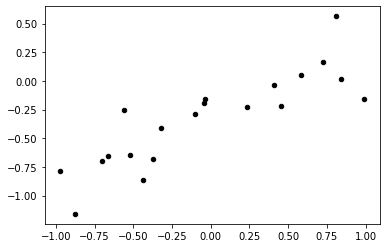

In [138]:
plot_data(X,t)

In [139]:
# Test observations 
X_test = np.linspace(-1, 1, 100).reshape(-1, 1)

# Function values without noise 
y_true = f(X_test, noise_variance=0)

# "Design matrix" of test observations
Phi_test = expand(X_test, identity_basis_function)

In [140]:
## We won't see "truth".
# plot_data(X_test, y_true)
# Phi_test

In [141]:
from IPython.display import display, clear_output
from time import sleep

### Observed Data Visualization

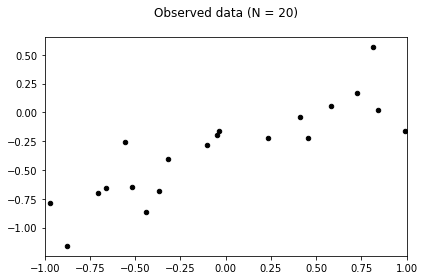

In [146]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1) 

for i, N in enumerate(N_list):
    X_N = X[:N]
    t_N = t[:N]
    
    ax.cla()
    ax.set_xlim(-1,1)
    ax.scatter(X_N, t_N, marker='o', c="k", s=20)
    ax.set_title(f'Observed data (N = {N})\n')

    fig.tight_layout()
    display(fig)

    sleep(0.5)
    clear_output(wait = True)

### Posterior Density Visualization

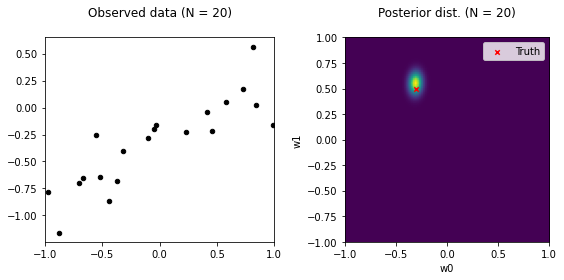

In [147]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

for i, N in enumerate(N_list):
    X_N = X[:N]
    t_N = t[:N]

    # Design matrix of training observations
    Phi_N = expand(X_N, identity_basis_function)
    
    # Mean and covariance matrix of posterior
    m_N, S_N = posterior(Phi_N, t_N, alpha, beta)
       

    ax = axs[0]
    ax.cla()
    ax.set_xlim(-1,1)
    ax.scatter(X_N, t_N, marker='o', c="k", s=20)
    ax.set_title(f'Observed data (N = {N})\n')
    
    ax = axs[1]
    ax.cla()
    plot_posterior(m_N, S_N, f_w0, f_w1, ax=ax)
    ax.set_title(f'Posterior dist. (N = {N})\n')
    ax.legend()
    
    fig.tight_layout()
    display(fig)

    sleep(0.5)
    clear_output(wait = True)


## Sampled "functions", from posterior distribution

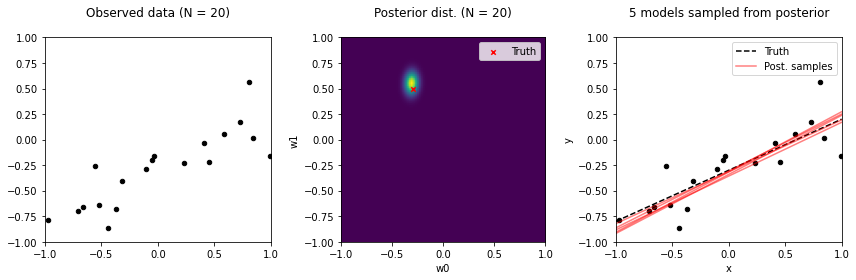

In [148]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

for i, N in enumerate(N_list):
    X_N = X[:N]
    t_N = t[:N]

    # Design matrix of training observations
    Phi_N = expand(X_N, identity_basis_function)
    
    # Mean and covariance matrix of posterior
    m_N, S_N = posterior(Phi_N, t_N, alpha, beta)

    # Draw 5 random weight samples from posterior and compute y values
    PS_num = 5
    w_samples = np.random.multivariate_normal(m_N.ravel(), S_N, PS_num).T
    y_samples = Phi_test.dot(w_samples)
    

    ax = axs[0]
    ax.cla()
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.scatter(X_N, t_N, marker='o', c="k", s=20)
    ax.set_title(f'Observed data (N = {N})\n')
    
    ax = axs[1]
    ax.cla()
    plot_posterior(m_N, S_N, f_w0, f_w1, ax=ax)
    ax.set_title(f'Posterior dist. (N = {N})\n')
    ax.legend()
    
    ax = axs[2]
    ax.cla()
    plot_data(X_N, t_N, ax=ax)
    plot_truth(X_test, y_true, ax=ax)
    plot_posterior_samples(X_test, y_samples, ax=ax)
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_title(f'{PS_num} models sampled from posterior\n')
    ax.legend()
    
    fig.tight_layout()
    display(fig)

    sleep(0.5)
    clear_output(wait = True)


## Posterior Predictive Model

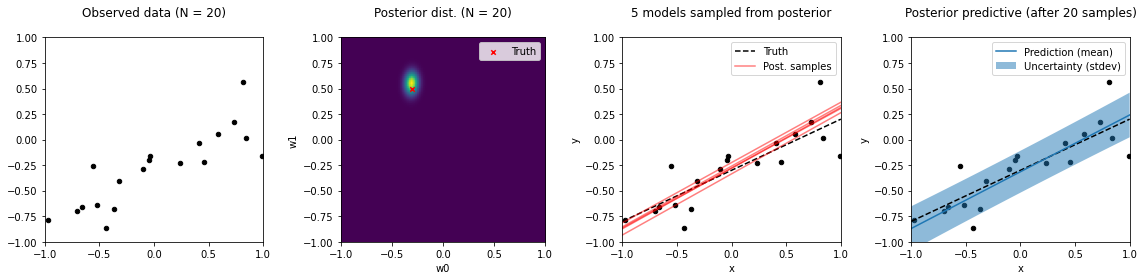

In [149]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16,4))

for i, N in enumerate(N_list):
    X_N = X[:N]
    t_N = t[:N]

    # Design matrix of training observations
    Phi_N = expand(X_N, identity_basis_function)
    
    # Mean and covariance matrix of posterior
    m_N, S_N = posterior(Phi_N, t_N, alpha, beta)
        
    # Draw 5 random weight samples from posterior and compute y values
    PS_num = 5
    w_samples = np.random.multivariate_normal(m_N.ravel(), S_N, PS_num).T
    y_samples = Phi_test.dot(w_samples)
    
    # Mean and variances of posterior predictive 
    y, y_var = posterior_predictive(Phi_test, m_N, S_N, beta)


    ax = axs[0]
    ax.cla()
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.scatter(X_N, t_N, marker='o', c="k", s=20)
    ax.set_title(f'Observed data (N = {N})\n')
    
    ax = axs[1]
    ax.cla()
    plot_posterior(m_N, S_N, f_w0, f_w1, ax=ax)
    ax.set_title(f'Posterior dist. (N = {N})\n')
    ax.legend()
    
    ax = axs[2]
    ax.cla()
    plot_data(X_N, t_N, ax=ax)
    plot_truth(X_test, y_true, ax=ax)
    plot_posterior_samples(X_test, y_samples, ax=ax)
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_title(f'{PS_num} models sampled from posterior\n')
    ax.legend()
    
    ax = axs[3]
    ax.cla()
    plot_data(X_N, t_N, ax=ax)
    plot_truth(X_test, y_true, label=None, ax=ax)
    plot_predictive(X_test, y, np.sqrt(y_var), ax=ax)
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_title(f'Posterior predictive (after {N} samples)\n')
    ax.legend()
    
    fig.tight_layout()
    display(fig)

    sleep(0.5)
    clear_output(wait = True)
